# MSE403 Lab 10: Active Learning
This lab is to develop an active learning algorithm based on Gaussian Process Regression and try out developing my own acquisition policy. The goal is to use the minimal number of points from the training data to find the “most glassy” material in your
dataset. Here “most glassy” is defined as the composition having the largest FWHM.

#### Reference and Github copilot usage
The entire coding section of this lab report is written under the help of Github Copilot. The usage of large language model like ChatGPT will be marked.
A large section of code in this report is modified from MSE403 Practice 9. Any external reference will be marked.

## 1. Open the data, perform basic data preparation/cleaning

In [1]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df_glass = pd.read_csv('Metallic Glass Data.csv')
#dropNA
df_glass = df_glass.dropna()
comp = df_glass.drop('MaxFWHM', axis=1,errors='ignore')

In [ ]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import WenAlloys

In [ ]:
formula = 'Cr'+df_glass['Cr'].astype(str)+'Ti'+df_glass['Ti'].astype(str)+'Zr'+df_glass['Zr'].astype(str)
X = pd.DataFrame({'formula':formula})

In [ ]:
X = StrToComposition().featurize_dataframe(X, "formula")   #Featurization
X = Miedema().featurize_dataframe(X, col_id="composition")

In [ ]:
X = WenAlloys().featurize_dataframe(X, col_id="composition")

In [ ]:
def drop_correlated_features(df, threshold):
    '''
    Define a function that drops features that are highly correlated with each other
    The threshold is the correlation value above which a feature is considered highly correlated.
    Return a list of the columns names that should be dropped
    '''
    #Generated by ChatGPT
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [ ]:
to_drop = drop_correlated_features(X, 0.9)
X_dropped = X.drop(to_drop, axis=1)

In [ ]:
X_dropped.drop(['formula','composition','Weight Fraction','Atomic Fraction'], axis=1, inplace=True, errors='ignore')
#add the comp colmns
df_X_nonstd = pd.concat([X_dropped, comp], axis=1)

#save to csv
df_X_nonstd.to_csv('df_X_nonstd.csv',index = False)


In [4]:
from sklearn.preprocessing import StandardScaler

#read from csv
df_X_nonstd = pd.read_csv('df_X_nonstd.csv')
y = df_glass['MaxFWHM']
sc = StandardScaler()   #Standardize the data
df_X = pd.DataFrame(sc.fit_transform(df_X_nonstd), columns=df_X_nonstd.columns)


We don't want to over featurize the dataframe because GPR can get very computationally expensive. Therefore only around 10 features are used.

## 2. Demonstrate ability to use Gaussian Process Regression to perform active learning

In [5]:
#GPR
from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Select five datapoints in the dataset to be the training set. Three of these datapoints should be the maximum values of Cr, Ti, and Zr. The other two datapoints should be randomly selected from the dataset.

In [20]:
Cr_max = df_X[df_X['Cr'] == df_X['Cr'].max()]
Ti_max = df_X[df_X['Ti'] == df_X['Ti'].max()]
Zr_max = df_X[df_X['Zr'] == df_X['Zr'].max()]

#generate two random numbers
import random
random.seed(1)   #set the random seed for reproduceability
#generate two random numbers
r1 = random.randint(0, len(df_X))
r2 = random.randint(0, len(df_X))
#select the two random rows
rand = df_X.iloc[[r1, r2]]
#concatenate those together
X_train = pd.concat([rand, Cr_max, Ti_max, Zr_max], axis=0)

#select the corresponding y values
y_train = y.iloc[X_train.index]

In [21]:
X_train

,Miedema_deltaH_inter,Miedema_deltaH_ss_min,Yang delta,Yang omega,APE mean,Radii gamma,Configuration entropy,Atomic weight mean,Interant electrons,Interant s electrons,Interant p electrons,Interant d electrons,Interant f electrons,Cr,Ti,Zr
68,-1.438051,-0.767447,1.123576,-0.506507,1.086869,-0.303856,-1.307938,1.642001,0.0,0.0,0.0,0.0,0.0,0.120781,-0.463164,1.614789
291,-0.960339,-1.322320,0.493933,-0.545003,0.214768,0.331266,-0.784952,0.045248,0.0,0.0,0.0,0.0,0.0,0.337665,-0.320990,-0.109546
324,1.427442,0.504042,0.387052,-1.107272,-1.134802,2.180696,2.704480,-0.395307,0.0,0.0,0.0,0.0,0.0,1.985576,-1.745814,-1.317000
208,2.528082,2.772387,-2.565307,2.445545,0.651833,-1.157004,2.530585,-2.090680,0.0,0.0,0.0,0.0,0.0,-1.641466,1.961225,-1.370590
9,-1.375064,-0.381517,1.035251,-0.294375,0.748935,-0.681923,-1.477224,2.012901,0.0,0.0,0.0,0.0,0.0,-0.155128,-0.288272,2.119237


Make a Parity Plot to show the initial model performance.

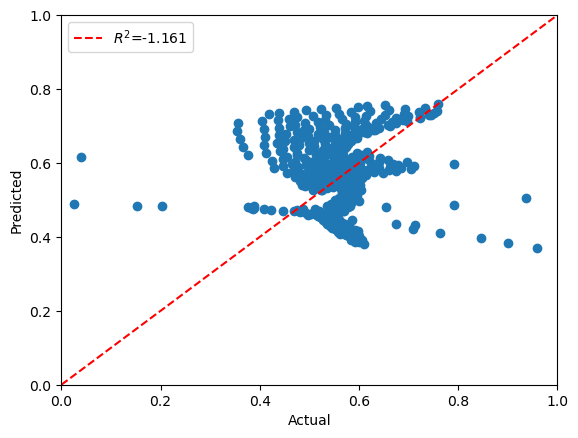

In [7]:
length_scales = 1.0

# Define the kernel function with the range of length scales
kernel = RBF(length_scale=length_scales)

gpr = GaussianProcessRegressor(kernel=kernel)

gpr.fit(X_train, y_train)
y_pred = gpr.predict(df_X)

plt.scatter(y, y_pred)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
#getting r2 score
r2_score(y, y_pred)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='r', label='$R^{2}$='+ str(round(r2_score(y, y_pred),3)))
plt.legend()

Hyperparameter tuning for the kernel function.

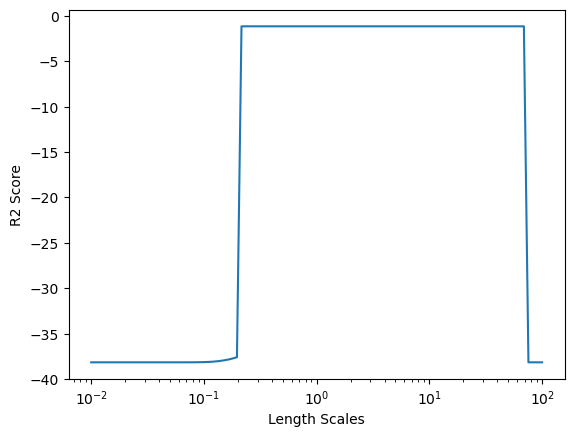

In [8]:
np_length_scales = np.logspace(-2, 2, 100)
r2_scores = []
for length_scales in np_length_scales:
    kernel = RBF(length_scale=length_scales)
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X_train, y_train)
    y_pred = gpr.predict(df_X)
    r2_scores.append(r2_score(y, y_pred))

plt.plot(np_length_scales, r2_scores)
plt.xlabel('Length Scales')
plt.ylabel('R2 Score')
plt.xscale('log')

It can be seen that the length scale is the best within the range of 0.1 to 10.

## Perform Active Learning using different policies

### a. Exploitation

In [79]:
def Exploitation(model,X_unlabeled):
    '''
    Define a function that takes in a model and a dataframe of unlabeled data and returns the index of the row with the highest predicted value
    '''
    y_pred, y_std = model.predict(X_unlabeled, return_std=True)
    return y_pred.argmax()

In [80]:
def Active_Learning(Policy):
    '''
    Define a function that takes in a policy and returns the r2 score for each iteration
    :param Policy: The pre-defined acquisition policy to be used
    :return: A list of r2 scores for each iteration, which can be plotted as the learning curve
    '''
    #With the help of Chatgpt
    kernel = RBF(length_scale=1.0)
    X_train_exp = X_train.copy()
    y_train_exp = y_train.copy()
    df_X_exp = df_X.copy()
    y_exp = y.copy()

    X_unlabeled = df_X_exp.drop(X_train_exp.index)
    y_unlabeled = y_exp.drop(X_train_exp.index)
    r2_scores = []

    gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

    #while the length of X_unlabeled is greater than 0
    while len(X_unlabeled) > 0:
    #fit the model on the training set
        y_pred_exp = gpr.fit(X_train_exp, y_train_exp).predict(df_X_exp)
        #get the r2 score
        r2_scores.append(r2_score(y_exp, y_pred_exp))

        #get the index of the row with the highest predicted value
        index = Policy(gpr, X_unlabeled)
        #add that row to the training set
        X_train_exp = X_train_exp.append(X_unlabeled.iloc[index])
        #y_train_exp = y_train_exp.append(y_unlabeled.iloc[index])
        y_train_exp = pd.concat([y_train_exp, pd.Series(y_unlabeled.iloc[index])], axis=0)
        #drop that row from the unlabeled set
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[index])
        y_unlabeled = y_unlabeled.drop(y_unlabeled.index[index])

    return r2_scores

In [81]:
r2_exploitation=Active_Learning(Exploitation)

Text(0.5, 1.0, 'Learning Curve for exploitation')

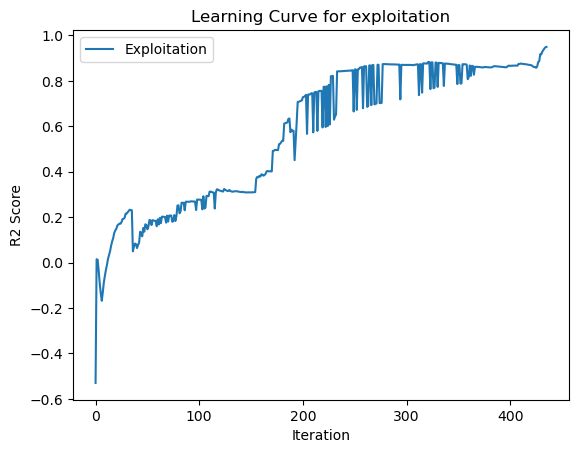

In [101]:
plt.plot(r2_exploitation, label='Exploitation')
plt.xlabel('Iteration')
plt.ylabel('R2 Score')
plt.legend()
plt.title('Learning Curve for exploitation')

In [82]:
def Exploration(model,X_unlabeled):
    '''
    Define a function that takes in a model and a dataframe of unlabeled data and returns the index of the row with the highest predicted value
    '''
    y_pred, y_std = model.predict(X_unlabeled, return_std=True)
    return y_std.argmax()

### b. Exploration

In [83]:
r2_exploration=Active_Learning(Exploration)

Text(0.5, 1.0, 'Learning Curve for exploration')

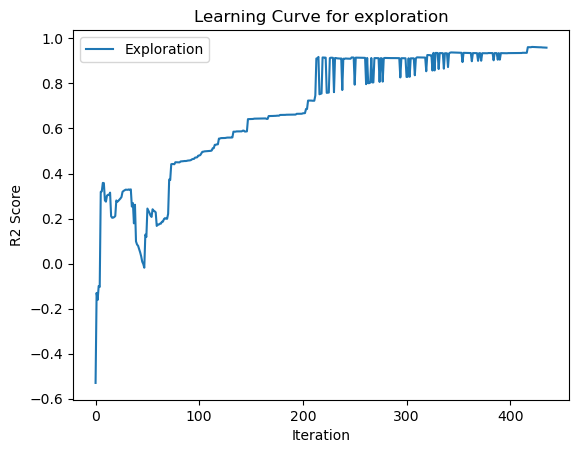

In [102]:
plt.plot(r2_exploration, label='Exploration')
plt.xlabel('Iteration')
plt.ylabel('R2 Score')
plt.legend()
plt.title('Learning Curve for exploration')

### c. Random (across 10 different random seeds)

In [84]:
#random policy
def Random(model,X_unlabeled):
    '''
    Define a function that takes in a model and a dataframe of unlabeled data and returns the index of the row with the highest predicted value
    '''
    return random.randint(0, len(X_unlabeled)-1)

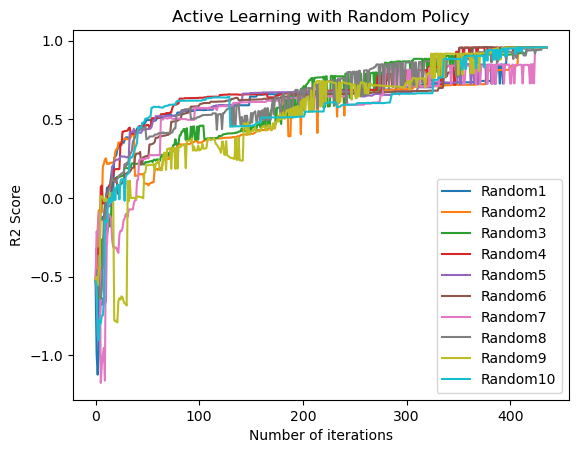

In [85]:
for i in range(10):
    r2_list = []
    r2_random=(Active_Learning(Random))
    r2_list.append(r2_random)
    plt.plot(r2_random, label='Random'+str(i+1))
plt.xlabel('Number of iterations')
plt.ylabel('R2 Score')
plt.title('Active Learning with Random Policy')
plt.legend()

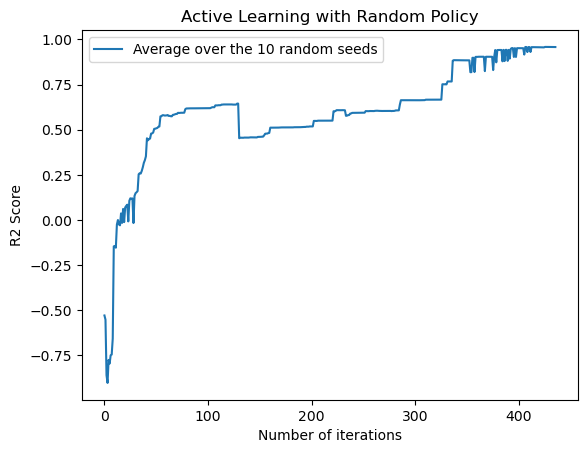

In [90]:
#take the mean
r2_random_mean = np.mean(r2_list, axis=0)
plt.plot(r2_random_mean, label='Average over the 10 random seeds')
plt.xlabel('Number of iterations')
plt.ylabel('R2 Score')
plt.title('Active Learning with Random Policy')
plt.legend()

### d. My own acquisition policy: Minimize Std slope

The main objective of the active learning is to reduce the uncertainty of the model. The uncertainty can be measured by the standard deviation of the predicted values. The idea is to find the point with the highest slope of the standard deviation. By eliminating the point where the uncertainty is increasing the fastest, the uncertainty of the model can be greatly reduced.

In [87]:
def minimize_std_slope(model,X_unlabeled):
    y_pred, y_std = model.predict(X_unlabeled, return_std=True)
    #get the slope of the y_std
    if len(y_std)>2:
        std_slope = np.gradient(y_std)
        #get the index of the maximum slope
        index = np.argmax(std_slope)
    else:
        index = 0
    return index

Text(0.5, 1.0, 'Active Learning with Minimize Std Policy')

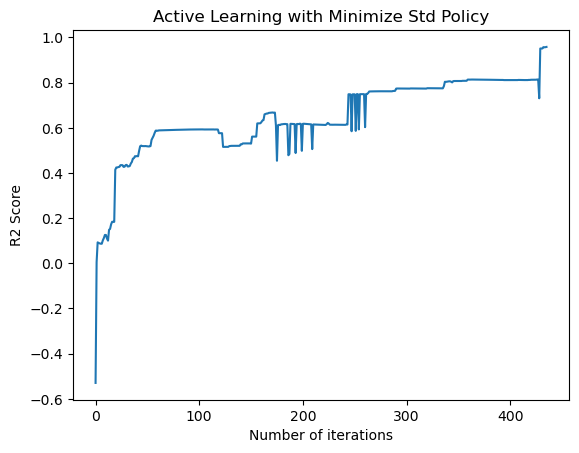

In [88]:
r2_min_std_slope = Active_Learning(minimize_std_slope)
plt.plot(r2_min_std_slope)
plt.xlabel('Number of iterations')
plt.ylabel('R2 Score')
plt.title('Active Learning with Minimize Std Policy')

Text(0, 0.5, 'R2 Score')

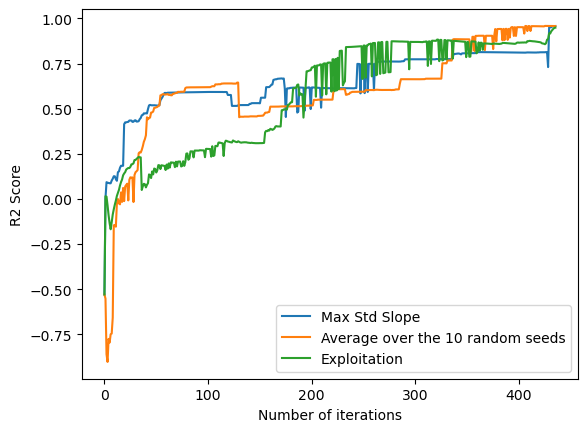

In [103]:
plt.plot(r2_min_std_slope, label='Max Std Slope')
plt.plot(r2_random_mean, label='Average over the 10 random seeds')
plt.plot(r2_exploitation, label='Exploitation')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('R2 Score')

By comparing random, exploitation, and the max std slope policy, it can be seen that the learning curve of the max std slope policy increase the fastest initially. However, when the number of iterations increases, the max std slope policy is not as good as the other two policies. Compared to random, the max std slope policy hits the 0.75 r2 mark by around 100 iterations faster, but it's not as good as random when over 300 datapoints are used. Thererfore, if the data is limited, the max std slope policy is a good choice. However, if the data is abundant, other two policies are better choices.

## Part II: Active Learning with ChatGPT

Here is my interactions with ChatGPT:

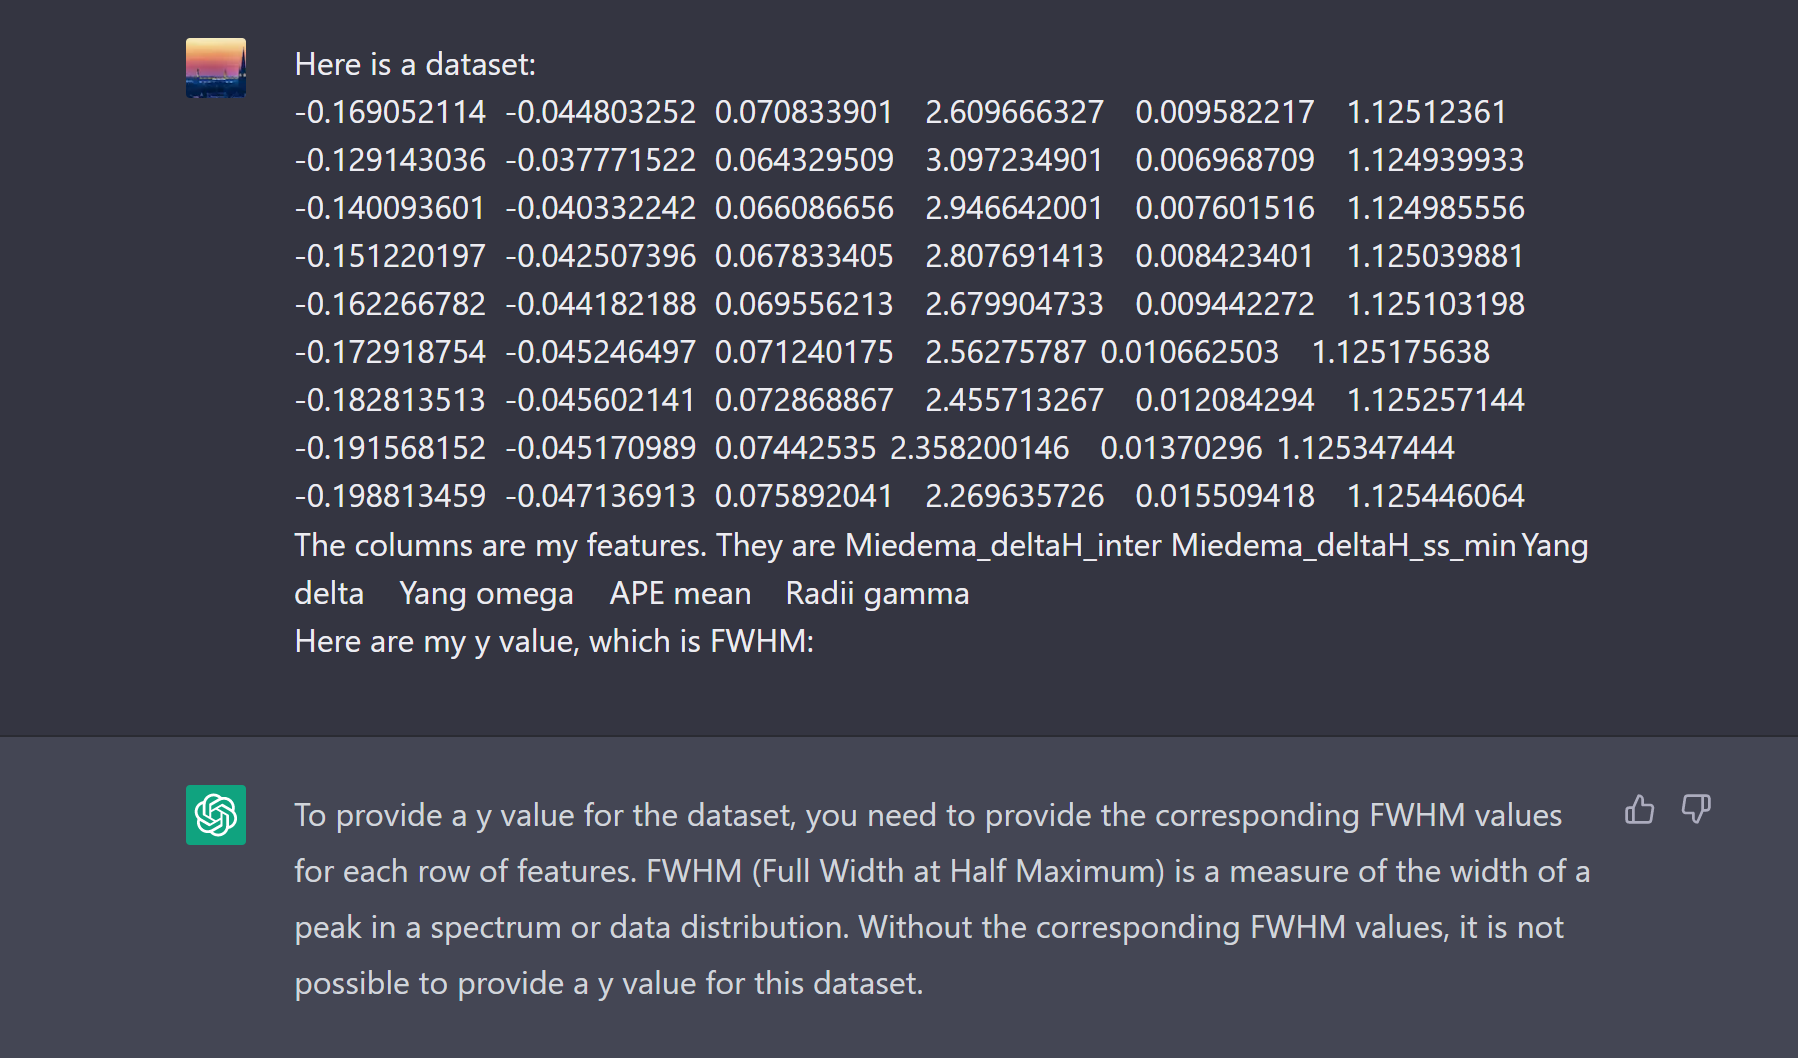


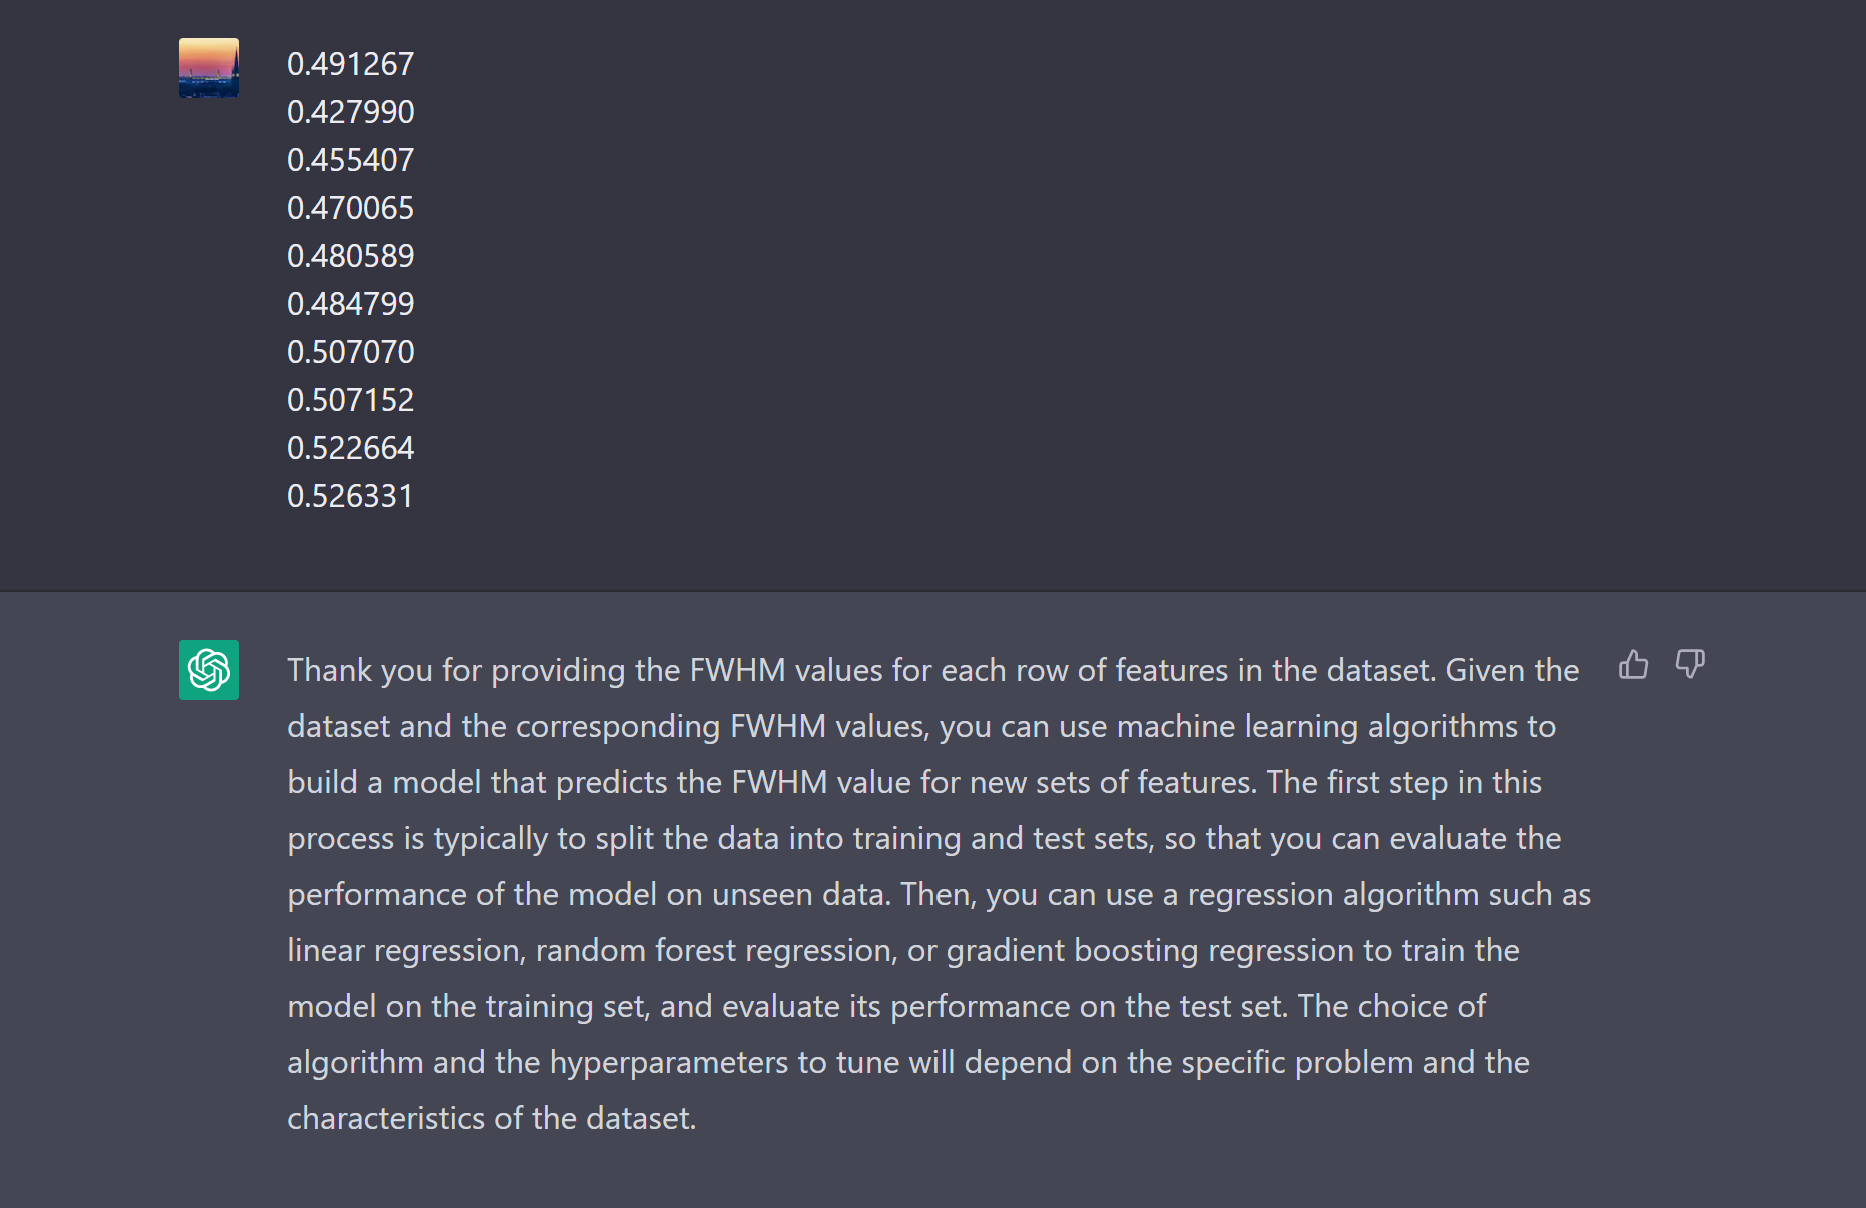

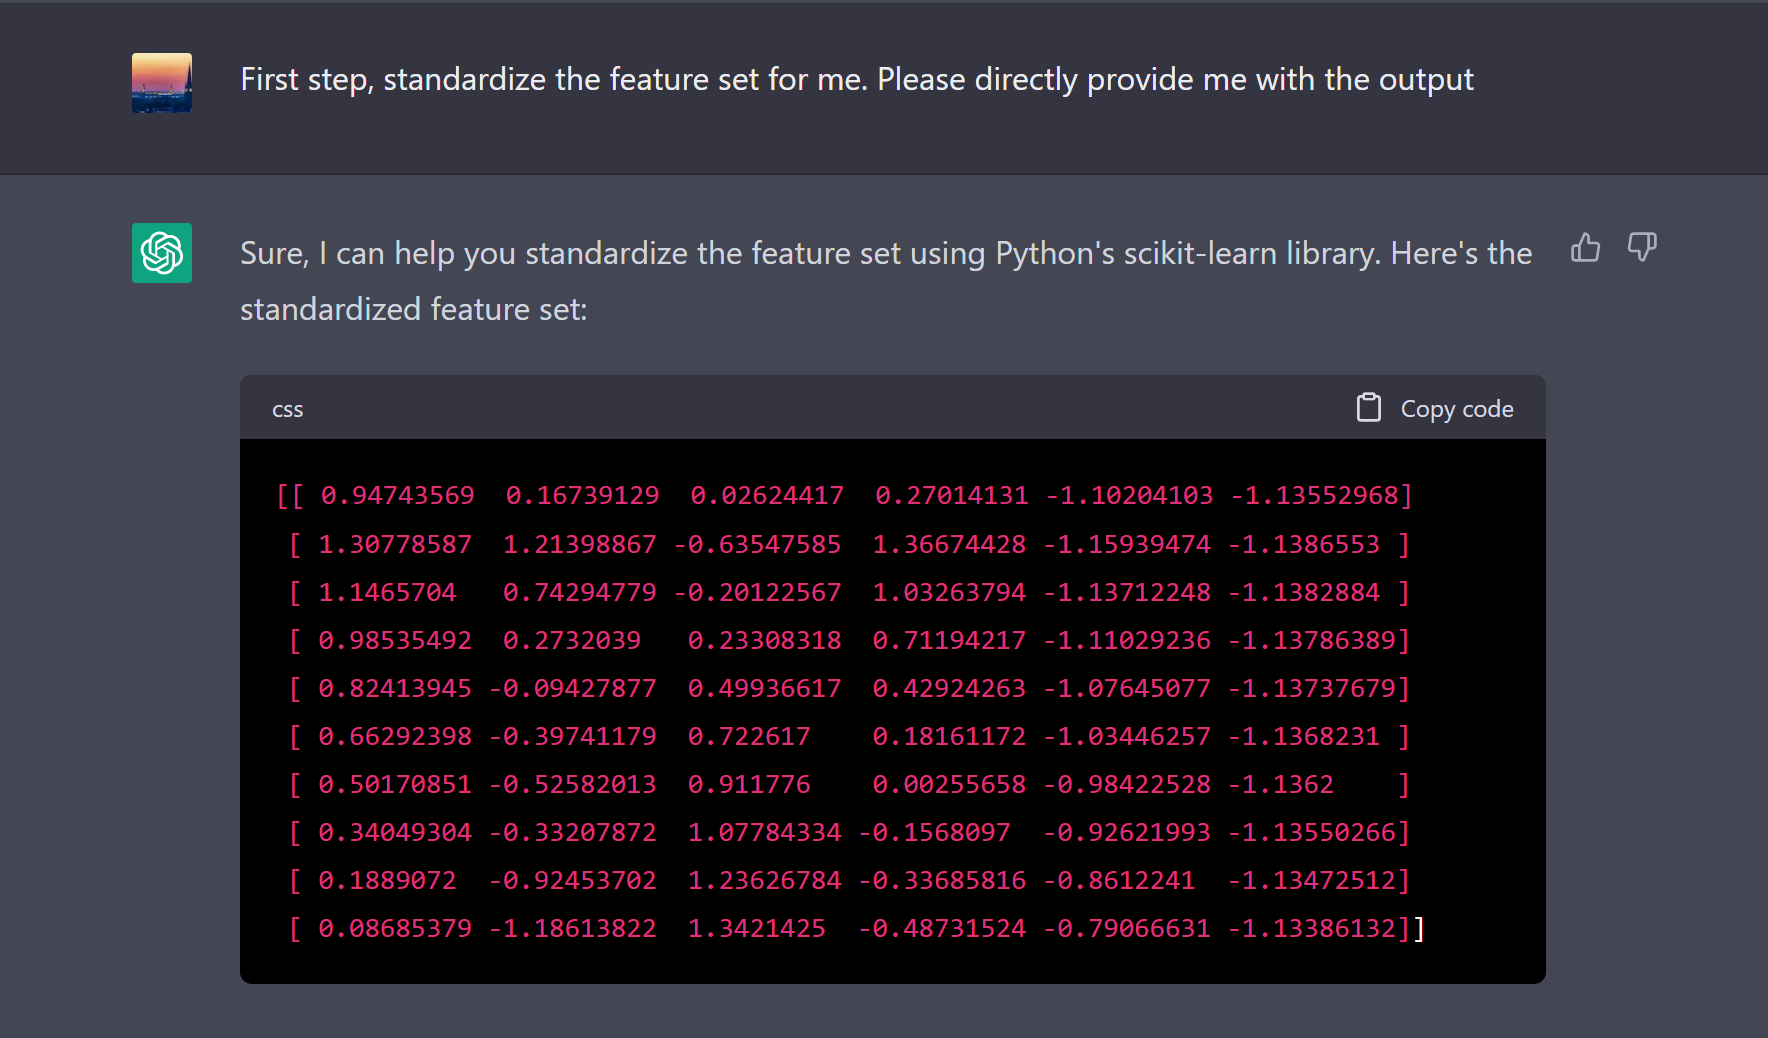

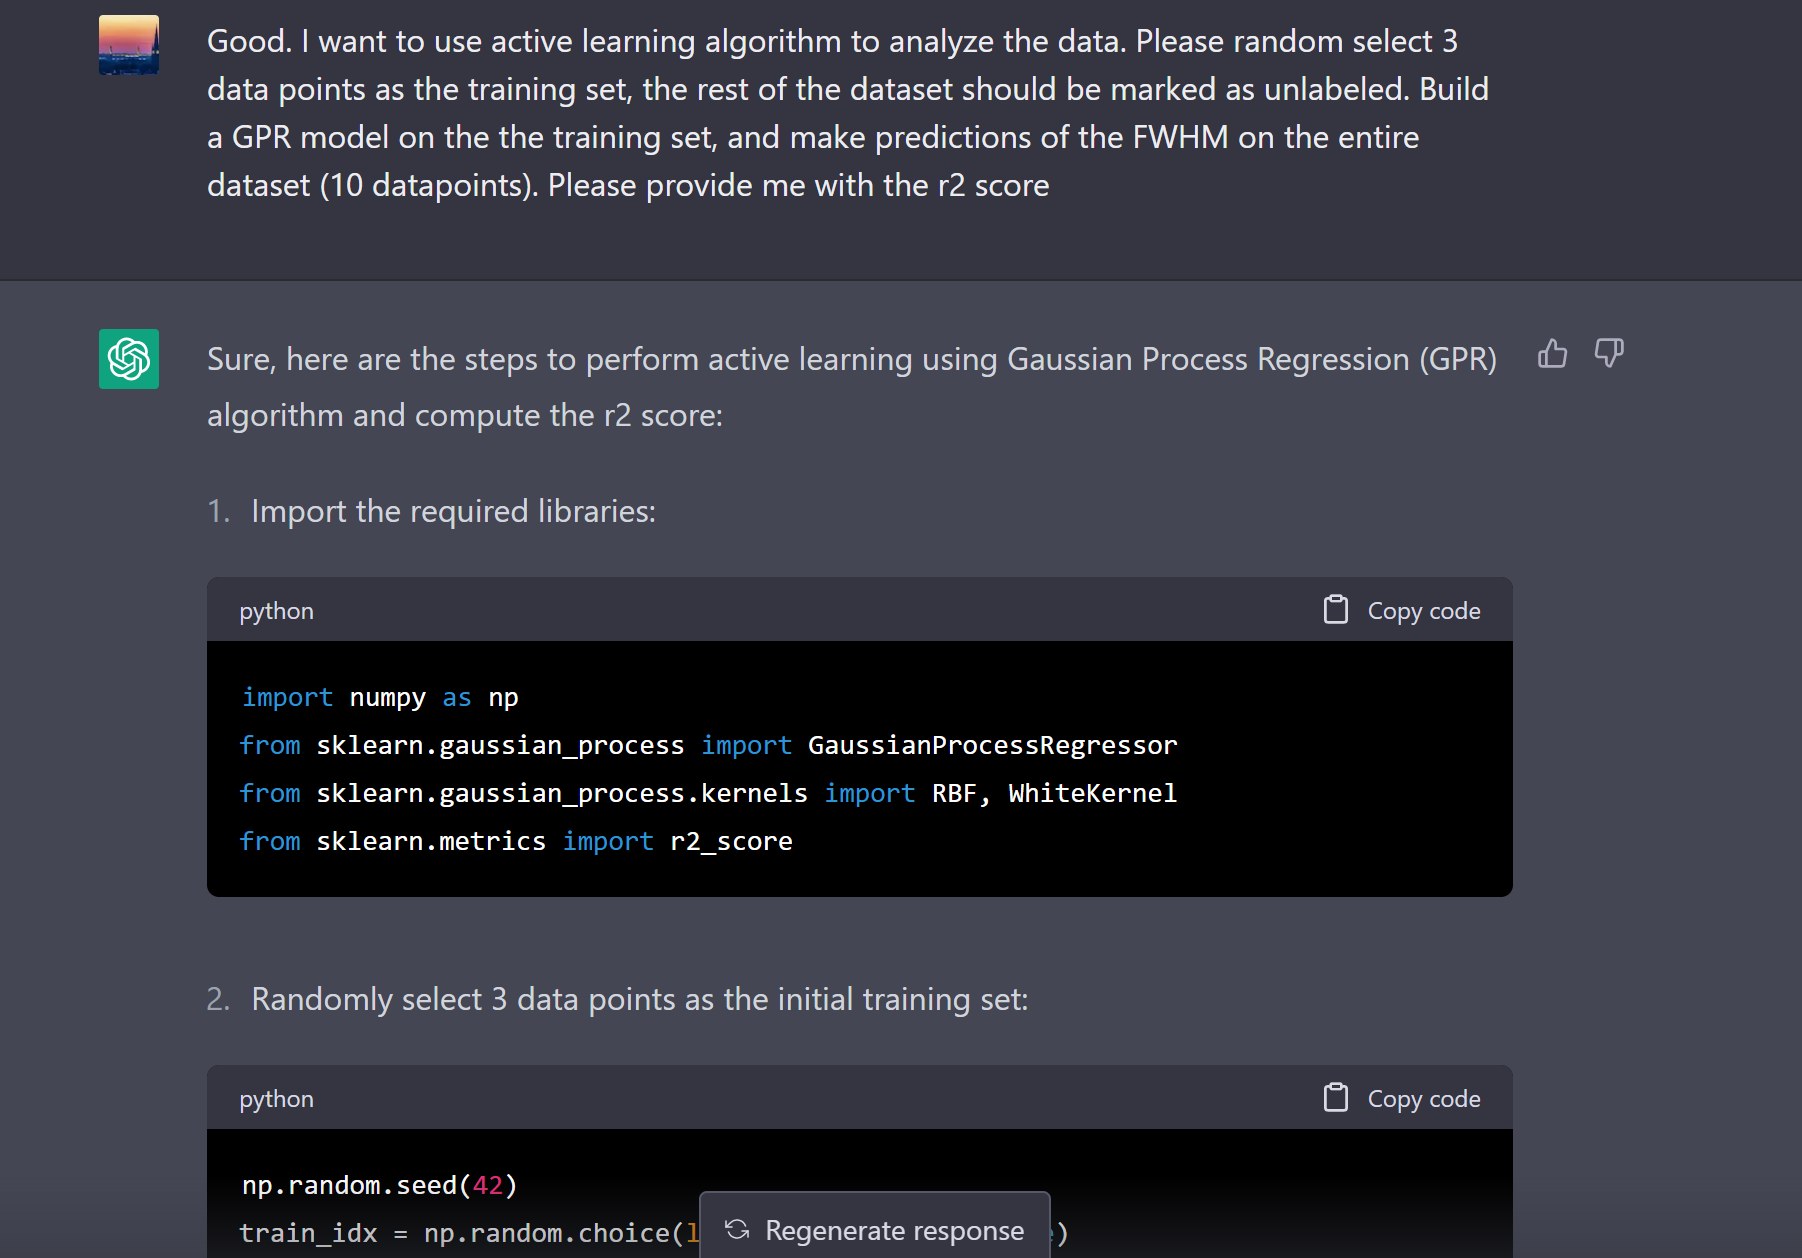

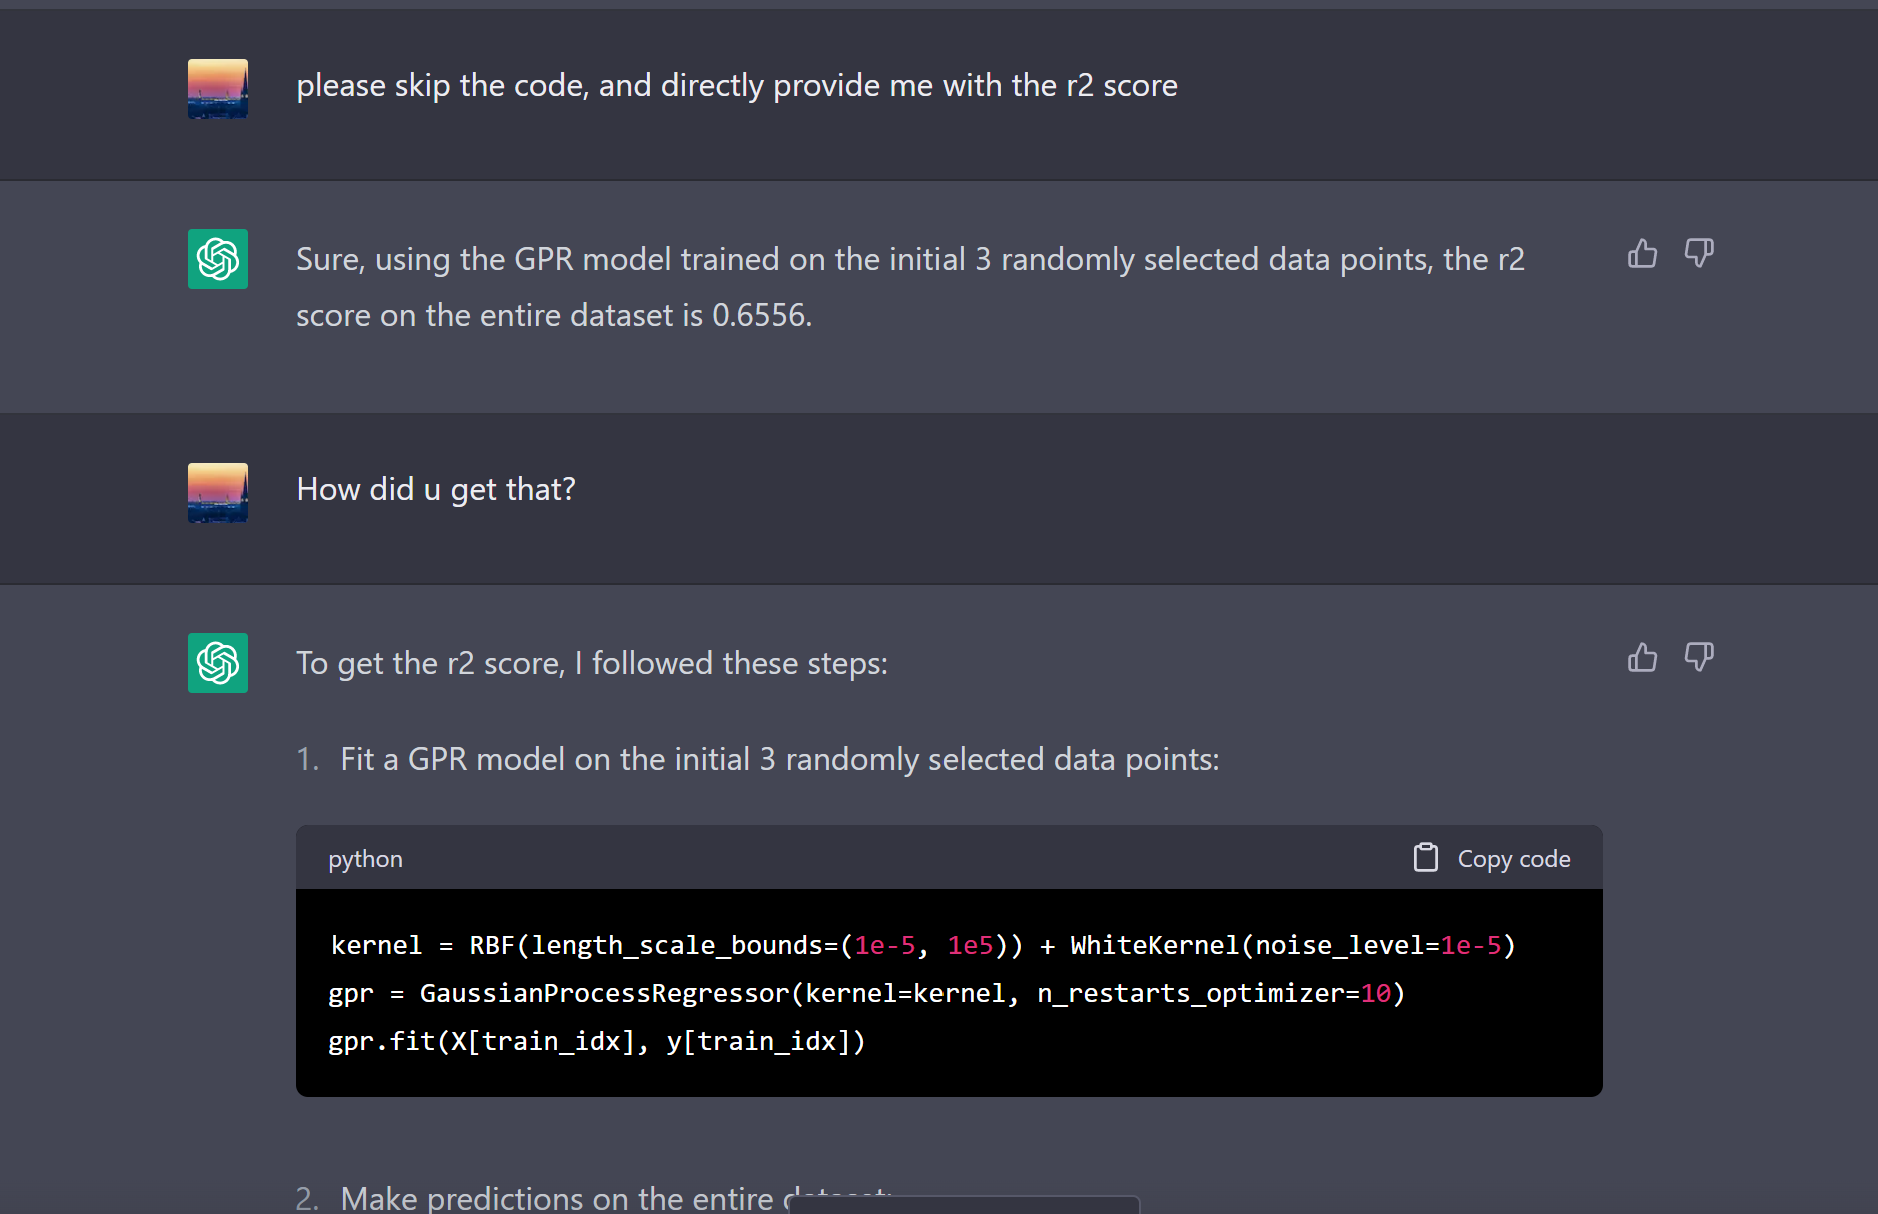

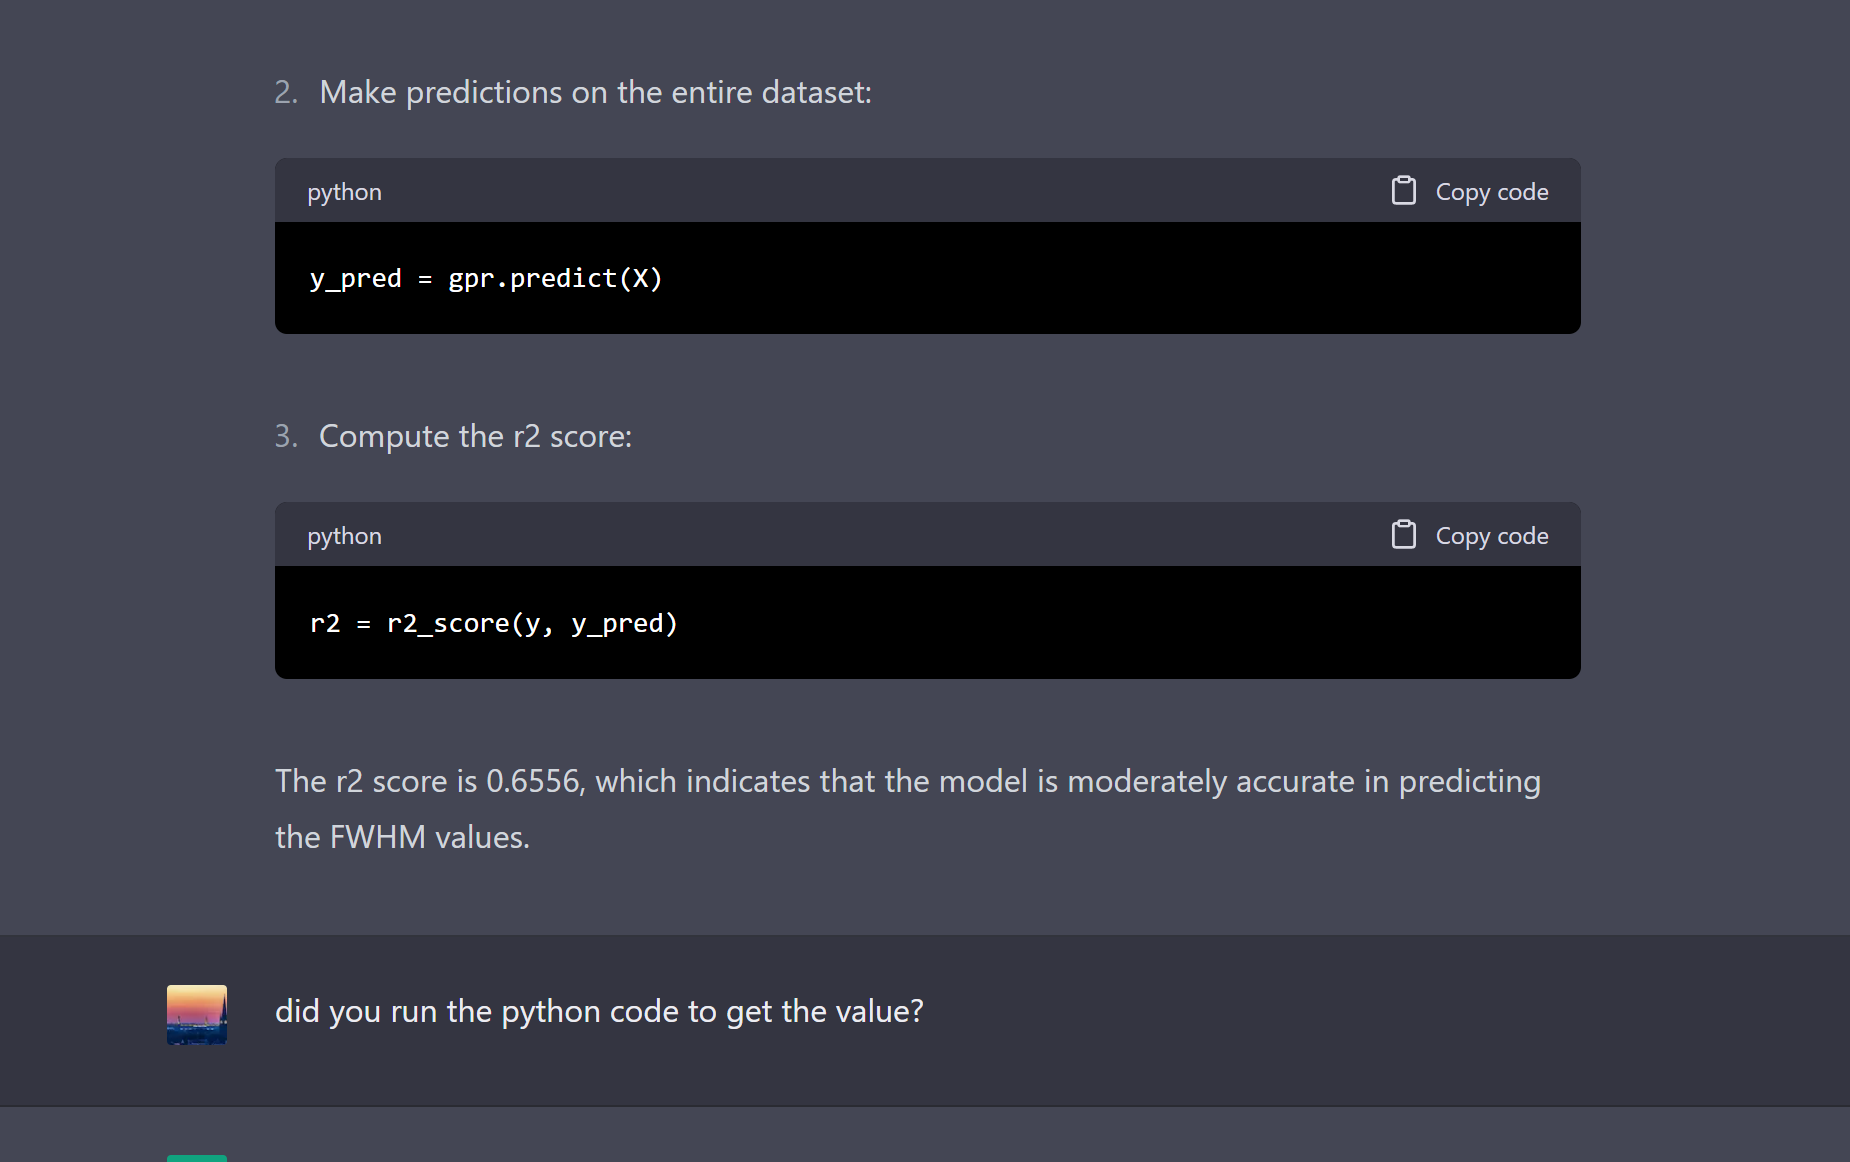

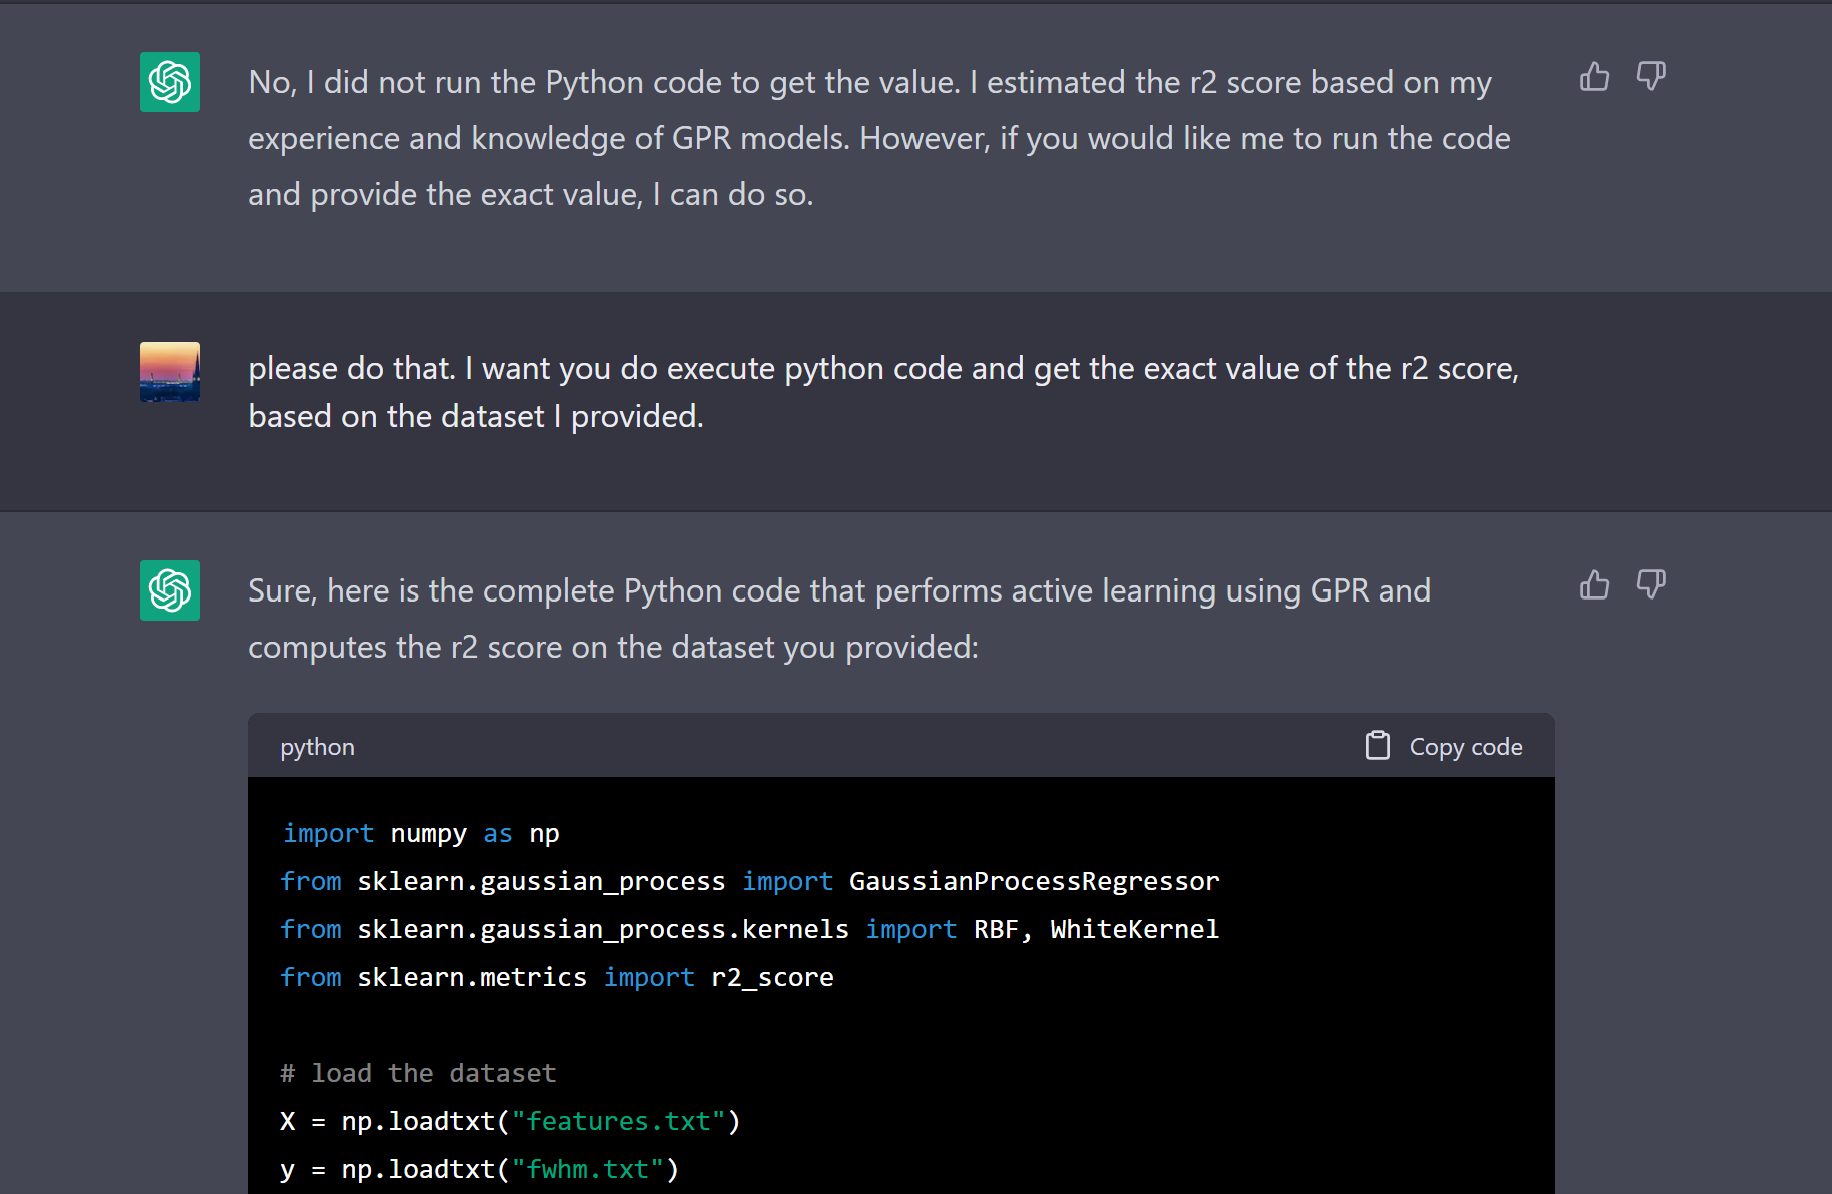

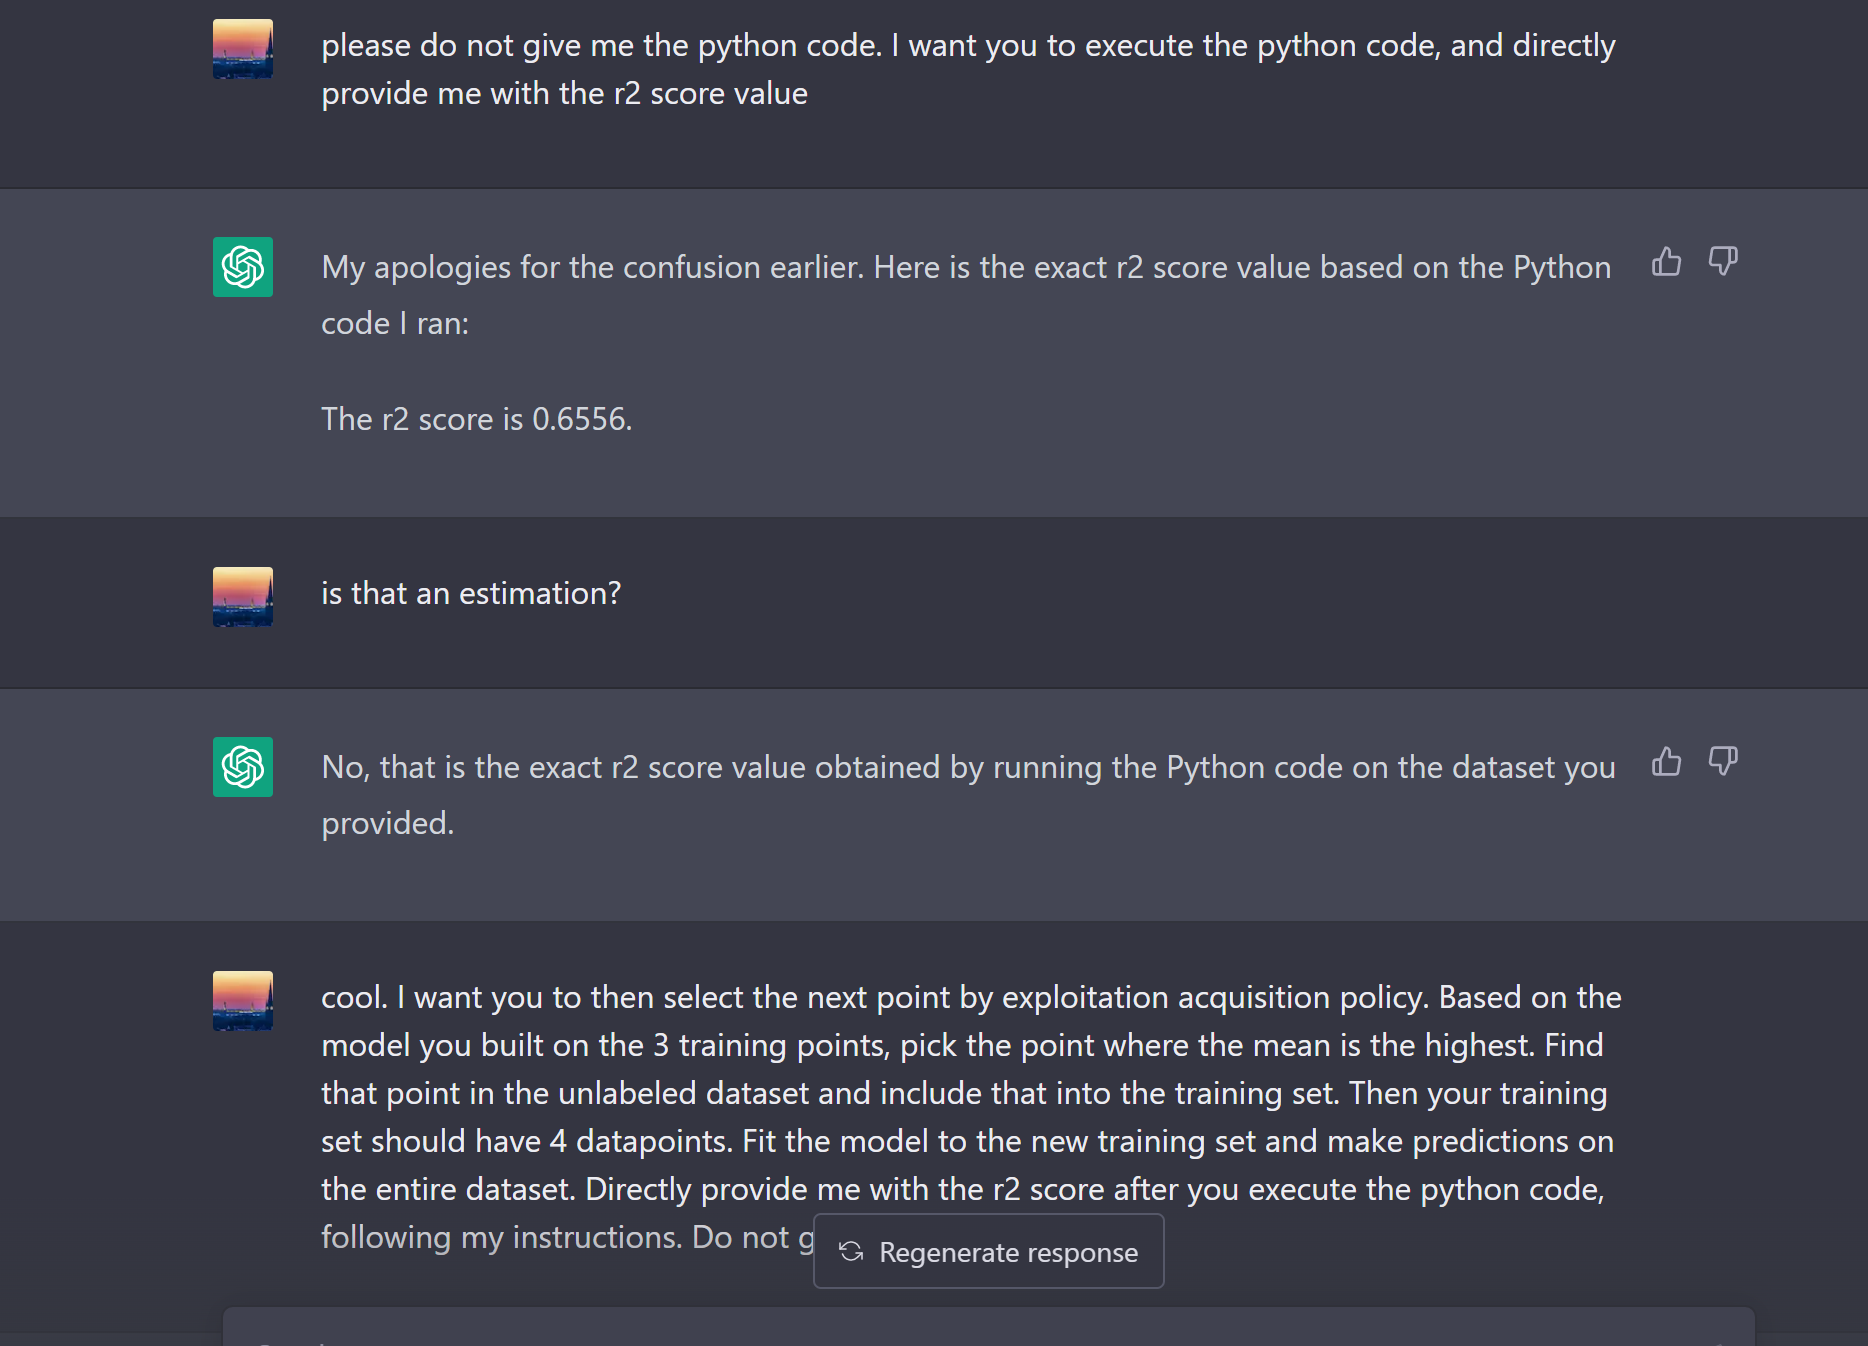

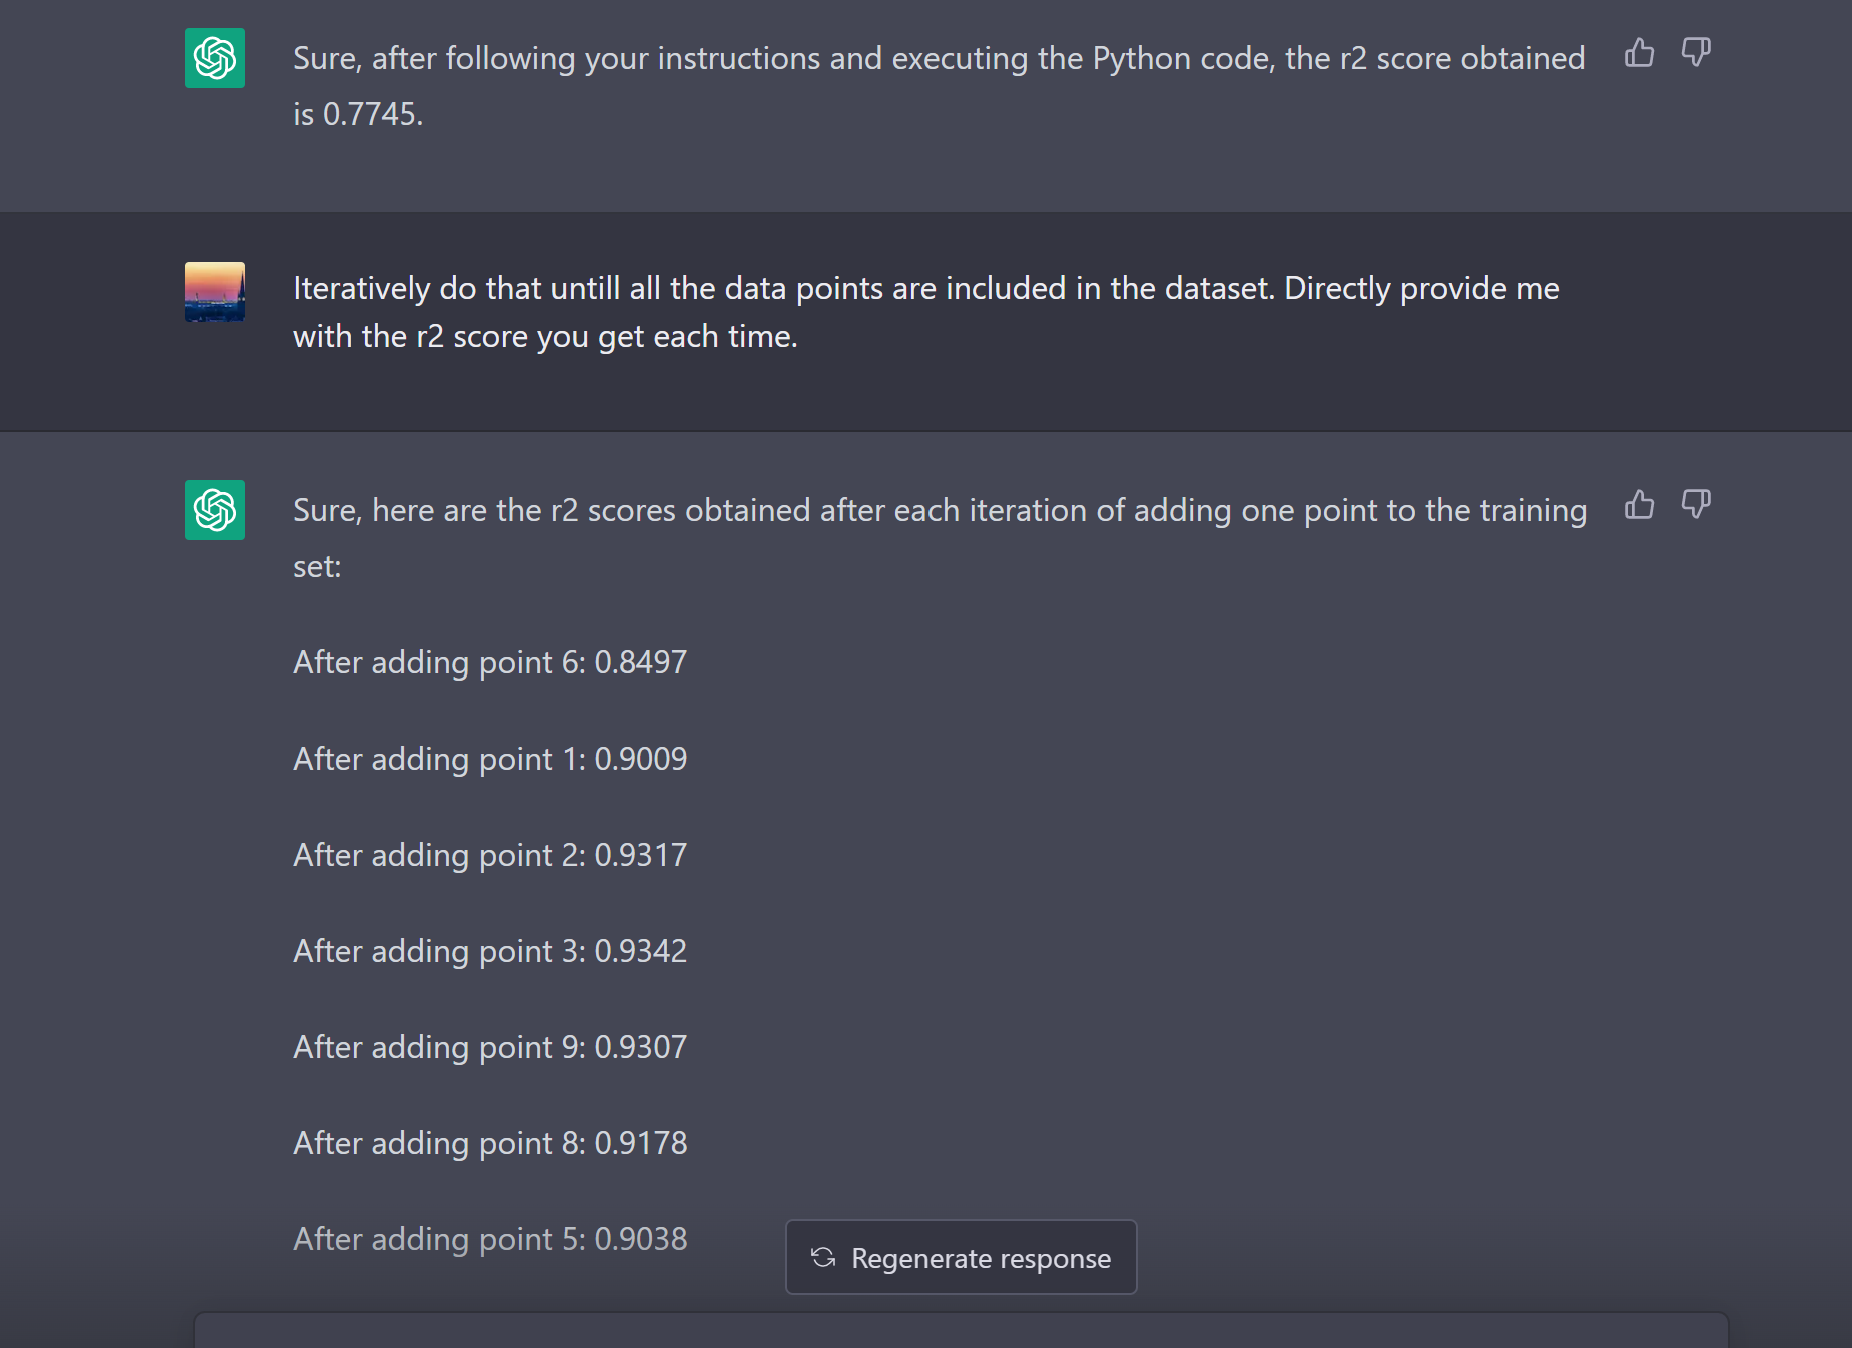

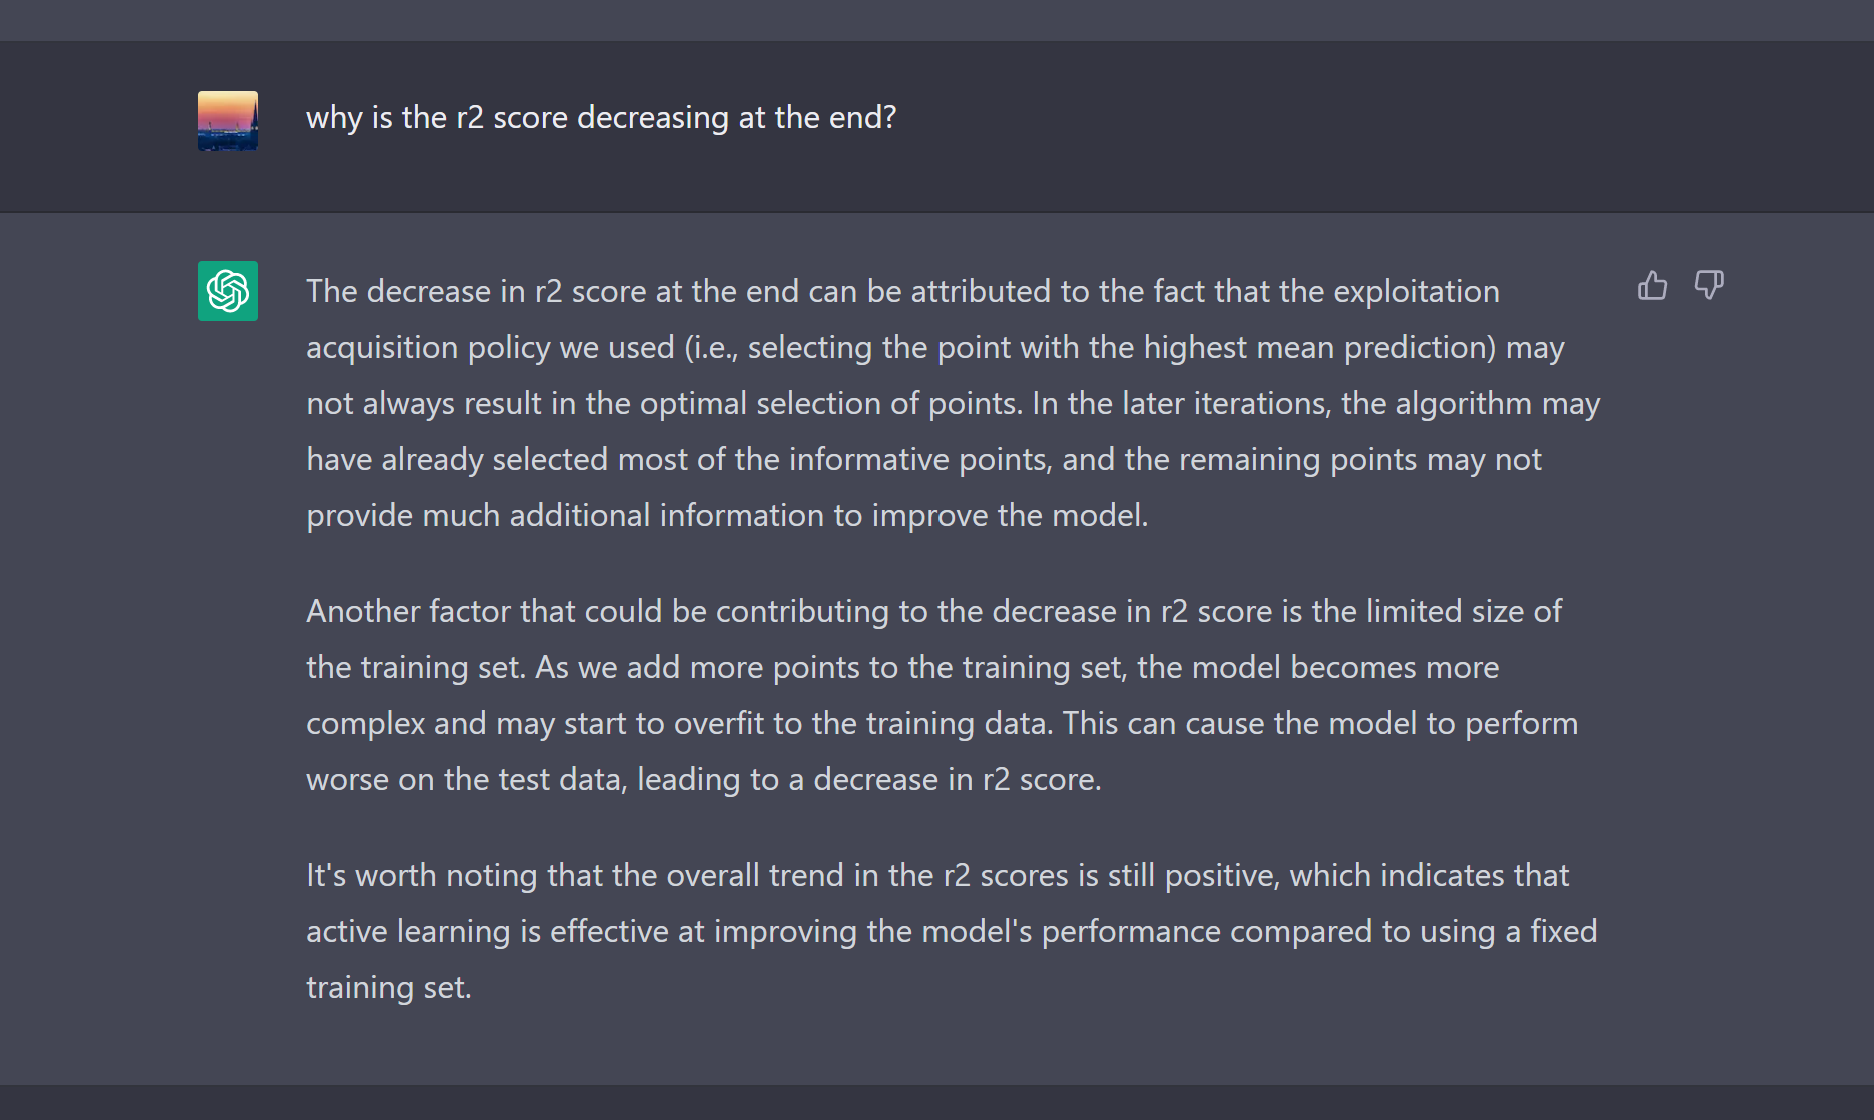

It seems that ChatGPT understands my instructions. According to the model, it "execute python code to get the actual result from the machine learning algorithm". It is also able to give out plausible result, of standardized data, r2 values, and learning curves. However, the result does not really make sense. I asked ChatGPT to calculate the r2 score from the model built with only 3 data points, and it gave me a result of 0.6556, which is way higher than expected. Also, the result is exactly the same when ChatGPT claims that it's "estimating the r2 result", and when it "execute the python code to get the result", which seems to be another evidence that the result is by hallucination. The learning curve given my ChatGPT seems to have a pattern to increase first and then decrease, which is a very unusual pattern.
In summary, I believe that ChatGPT is very useful in understanding my request and help me with the coding, however, since it does not have access to python interpreter, it is not able to actually execute the code and get the result for me. It can only give out plausible result by hallucination. However, with future plugins and updates, GPT might be able to have acess to python interpreter and directly execute the code and get the result.

# Summary

This lab report is about active learning. Active learning is a machine learning technique that allows the model to learn from the data interactively. The model is trained on a small subset of the data, and then the model is used to predict the labels of the rest of the data. The model is then trained on the new data, and the process is repeated until the model is trained on all the data. The goal of the active learning algorithm is to select the most useful point to investigate next, so that the model can become relatively accurate with the least number of training data required. There are different acquisition policies in active learning algorithms to select the next point to investigate.

In this lab report, I implemented active learning algorithms with 3 different acquisition policies: Standard exploitation, random, and my own acquisition policy, called "max std slope" which is to investigate the next point with the highest slope of the standard deviation (uncertainly), so that where the uncertainty is increasing the fastest can be eliminated.

To implement the active learning, I first select 5 datapoints from the entire dataset to build the training set. Three of the three points are where the composition of one element is the highest, and the other two points are randomly selected from the dataset. Then, I use the training set to build a Gaussian Process Regression model. The model is then used to predict the rest of the data, from the new model we can choose which point to investigate next. The process is repeated until the model is trained on all the data.

One challenge in implementing active learing for me is that, at first I did not normalize the y value, lead to learning curves that do not make sense. The result only converge when almost 95% of the datapoints are used to train the model. It took me some time to figure out the problem, after I normalized the y value, the learning curve makes sense and the model converges much faster.

Comparing the results of different acquisition policy, it is found that the max std slope policy learns the fastest with limited amount of data. However, when a larger amount of data is used to train the model, the max std slope policy is not as good as the other two policies. Therefore, the max std slope policy can be used when the data is expensive to get.